# Determining parameters


The Fourier transform of the convolutional line profile arising from planar faults, dislocations, and size effects can be evaluated as 

$$
A_{hkl}(L) = A_S(L)A_D(L)A_F(L),
$$

where the variable $L$ is relted to $\kappa$ through the Fourier-transform and $\kappa$ is defined as

$$
\kappa = \frac{2\sin \theta}{\lambda}.
$$

The profile can then be evaluated as 

$$
I(\kappa)_{hkl} = \int_{-\infty}^\infty e^{2\pi i \kappa L}A_{hkl}(L)dL.
$$

The observed spectrum is a linear combination of these. We therefore have to sum over the Miller-indices as

$$
I(\kappa) = \sum_{h,k,l}I_{hkl}^{max}I(\kappa-g_{hkl})_{hkl}.
$$

Generally, we assume that the lattice constant $a$, the Burgers vector $b$, and $C_{h00}$ are known for the sample. Then, the parameters to be determined are

- $\rho$
- $m$
- $\sigma$
- $q$
- $R^*$
- $\beta$ or $\alpha$, the planar fault probability

In addition, the peak locations and peak amplitudes are also to be determined.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [2]:
import matplotlib

In [3]:
%load_ext autoreload
%autoreload 2
%aimport  cmwp_profiles

In [4]:
from cmwp_profiles.peak_shapes import Peak, generate_multiple_peaks


In [5]:
N = 1024 * 8 


Here we initialize a Peak object

with the following properties.

$$a =0.36, b =0.255, C_{h00}=0.1. $$


The computational domain will correspond to $\kappa \in [0, \kappa_{max}]$ with $\kappa_{max}=14$. 

In [6]:
lattice_constant = 0.36



Let us also fix the following parameters

$$
\rho = 0.01, m = 10, R^* = 60, \sigma = 0.001,  q=2, B = 0.05
$$


In [7]:
rho_true = 0.01
m_true = 20
Rstar_true = 5
sigma_true = 0.1
q_true = 3
B_true = 0.05

Assuming an FCC lattice, we'll simulate a spectrum corresponding to the first 5 peaks.

In [8]:
np.random.seed(4)
intensities = np.random.rand(5,1)
offsets = (np.random.rand(5,1) -0.5) * 1e-3


In [9]:
h, k, l = 2, 0, 0
kappa_max = 14
N_fourier = 8192
lattice_constant = 0.36
burgers_vector = 0.255
Ch00 = 0.36
single_peak = Peak(kappa_max,
                    N_fourier, 
                    Ch00, 
                    burgers_vector,
                      lattice_constant, 
                      stacking_or_twin_fault='stacking',
                        approximation_wilkens='polynomial')


In [10]:
true_spectrum = generate_multiple_peaks(single_peak,
                                        m_true,
                                        sigma_true,
                                        rho_true,
                                        B_true,
                                        Rstar_true,
                                        q_true,
                                        peak_intensities=intensities,
                                       offset=offsets)

TypeError: generate_multiple_peaks() got multiple values for argument 'peak_intensities'

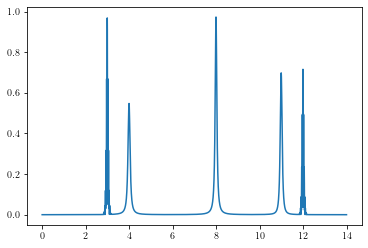

In [451]:
plt.plot(single_peak.positive_diffraction_vectors, true_spectrum)

Let us set up a loss function for the optimization. Combine all variables into a single vector first.

In [452]:
def unpack_x(x):
    m, sigma, B, rho, Rstar, q = x[:6]
    intensity = x[6:11].reshape(-1,1)
    offset = x[11:].reshape(-1,1)
    return m, sigma, B, rho, Rstar, q, intensity, offset

In [453]:
def loss(x):
    m, sigma, B, rho, Rstar, q = x[:6]
    intensity = x[6:11].reshape(-1,1)
    offset = x[11:].reshape(-1,1)
    spectrum = generate_multiple_peaks(single_peak,
                                        m,
                                        sigma,
                                        B,
                                        rho,
                                        Rstar,
                                        q,
                                        peak_intensities=intensity,
                                       offset=offset)
    return np.ravel(true_spectrum - spectrum)

In [454]:
true_x = np.concatenate(([m_true, sigma_true, B_true, rho_true, Rstar_true, q_true], *intensities, *offsets))

In [455]:
from scipy.optimize import least_squares

In [456]:
np.random.seed(3)
x_0 = true_x + (np.random.rand(16)*0.05)

In [457]:
res = least_squares(loss, x_0)

/Users/balintkaszas/temp/CMWP_ML/cmwp_profiles/cmwp_profiles/math_backend.py:127: RuntimeWarning: invalid value encountered in log
  return np.log(x)
/Users/balintkaszas/temp/CMWP_ML/cmwp_profiles/cmwp_profiles/math_backend.py:104: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x)
/Users/balintkaszas/temp/CMWP_ML/cmwp_profiles/cmwp_profiles/math_backend.py:139: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin(x)

KeyboardInterrupt



In [ ]:
m, sigma, B, rho, Rstar, q, intensity, offset = unpack_x(res.x)

In [ ]:
predicted_spectrum = generate_multiple_peaks(single_peak,
                                        m,
                                        sigma,
                                        B,
                                        rho,
                                        Rstar,
                                        q,
                                        peak_intensities=intensity,
                                       offset = offset)

In [ ]:
plt.plot(single_peak.positive_diffraction_vectors, true_spectrum, label = 'True spectrum')
plt.plot(single_peak.positive_diffraction_vectors, predicted_spectrum, label = 'With identified parameters')
plt.legend()
plt.xlabel('$\\kappa$')
plt.ylabel('Intensity')


In [ ]:
plt.semilogy(single_peak.positive_diffraction_vectors, np.abs(true_spectrum-predicted_spectrum), c='black')
plt.xlabel('$\\kappa$')
plt.ylabel('Error')


## Generate multiple spectra at once

In [741]:
domains = {'B': [0, 0.05],
           'm': [5., 100.],
           'sigma': [0.1, 1.],
           'rho': [0.0005, 0.05],
           'Rstar' : [2., 100.],
           'q' : [1.5, 2.3],
           'offset' : [-0.05, 0.05],
           'intensity' : [0, 1]
          }

def generate_spectra_in_domain(num_spectra, num_peaks, domains, seed = 0):
    torch.manual_seed(seed)
    params = {}
    
    params['m'] = (domains['m'][1] - domains['m'][0]) * torch.rand(1, num_spectra) + domains['m'][0]
    params['sigma'] = (domains['sigma'][1] - domains['sigma'][0]) * torch.rand(1, num_spectra) + domains['sigma'][0]
    params['B'] = (domains['B'][1] - domains['B'][0]) * torch.rand(1, num_spectra) + domains['B'][0]
    params['rho'] = (domains['rho'][1] - domains['rho'][0]) * torch.rand(1, num_spectra) + domains['rho'][0]
    params['Rstar'] = (domains['Rstar'][1] - domains['Rstar'][0]) * torch.rand(1, num_spectra) + domains['Rstar'][0]
    params['q'] = (domains['q'][1] - domains['q'][0]) * torch.rand(1, num_spectra) + domains['q'][0]
    params['intensity'] = (domains['intensity'][1] - domains['intensity'][0]) * torch.rand(num_peaks, num_spectra) + domains['intensity'][0]
    params['offset'] = (domains['offset'][1] - domains['offset'][0]) * torch.rand(num_peaks, num_spectra) + domains['offset'][0]
    return params
    
        

    

In [748]:
single_peak = Peak(14, 1024 * 8, 0.31, 0.255, lattice_constant,
                   phase='fcc', backend = 'torch',use_reduced_rho=True, stacking_or_twin_fault='twin', approximation_wilkens='polynomial')


In [749]:
num_spectra = int(1e3)
num_peaks = 5

In [750]:
parameters = generate_spectra_in_domain(num_spectra, num_peaks, domains)

In [751]:
%%time 
predicted_spectrum = generate_multiple_peaks(single_peak,
                                        parameters['m'],
                                        parameters['sigma'],
                                        parameters['rho'],
                                        parameters['Rstar'],
                                        parameters['q'],
                                        peak_intensities=parameters['intensity'],
                                             planar_fault_probability=parameters['B'],
                                       offset = parameters['offset'])

CPU times: user 25.9 s, sys: 4.35 s, total: 30.2 s
Wall time: 3.71 s


In [752]:
print(torch.__version__)

2.0.0


### Generating benchmark spectra

In [718]:
!mkdir benchmark_spectra

python(38167) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


### BCC material

We construct a synthetic spectrum of an iron sample with large crystallite size.

$a = 0.286$

$b = 0.248$    

$m = 50$

$\sigma = 0.3$

$\rho = 0.005$

$q = 1.28$

$R^* = 20$

$C_{h00} = 0.2548$

In [714]:
np.random.seed(3)
iron_sample = {}
iron_sample['Ch00'] = 0.2548
iron_sample['lattice_constant'] = 0.286
iron_sample['b'] = 0.248
iron_sample['m'] = 50
iron_sample['sigma'] = 0.3
iron_sample['rho'] = 0.005
iron_sample['q'] = 1.28
iron_sample['Rstar'] = 20
iron_sample['intensities'] = np.random.rand(5, 1)









In [715]:
single_peak_iron = Peak(14, 1024 * 8, iron_sample['Ch00'], iron_sample['b'], iron_sample['lattice_constant'],
                   phase='bcc', backend = 'numpy', approximation_wilkens='polynomial')


In [716]:
%%time 
predicted_spectrum_iron = generate_multiple_peaks(single_peak_iron,
                                        iron_sample['m'],
                                        iron_sample['sigma'],
                                        None,
                                        iron_sample['rho'],
                                        iron_sample['Rstar'],
                                        iron_sample['q'],
                                        peak_intensities = iron_sample['intensities'])

CPU times: user 31 ms, sys: 66.1 ms, total: 97.1 ms
Wall time: 14.2 ms


Text(0, 0.5, 'Intensity')

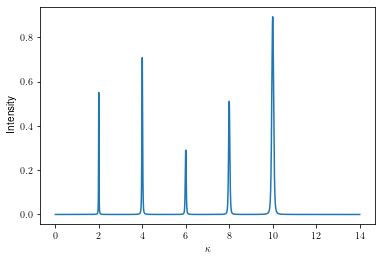

In [717]:
plt.plot(single_peak_iron.positive_diffraction_vectors, predicted_spectrum_iron)
plt.xlabel('$\\kappa$')
plt.ylabel('Intensity')


In [721]:
np.savetxt('benchmark_spectra/BCC_iron.dat', np.vstack((single_peak_iron.positive_diffraction_vectors,
                                                        predicted_spectrum_iron.ravel())).T)

### FCC material

Copper 

$a = 0.361$

$b = 0.255$    

$m = 20$

$\sigma = 0.3$

$\rho = 0.01$

$q = 2.33$

$B = 0.03$

$R^* = 8$

$C_{h00} = 0.3029$

In [722]:
np.random.seed(3)
copper_sample_1 = {}
copper_sample_1['Ch00'] = 0.3029
copper_sample_1['lattice_constant'] = 0.361
copper_sample_1['b'] = 0.255
copper_sample_1['m'] = 20
copper_sample_1['sigma'] = 0.3
copper_sample_1['rho'] = 0.01
copper_sample_1['q'] = 2.33
copper_sample_1['B'] = 0.03
copper_sample_1['Rstar'] = 8
copper_sample_1['intensities'] = np.random.rand(5, 1)


In [723]:
single_peak_copper_1 = Peak(14, 1024 * 8, copper_sample_1['Ch00'], copper_sample_1['b'], copper_sample_1['lattice_constant'],
                   phase='fcc', backend = 'numpy', stacking_or_twin_fault='twin', approximation_wilkens='polynomial')


In [724]:
predicted_spectrum_copper_1 = generate_multiple_peaks(single_peak_copper_1,
                                        copper_sample_1['m'],
                                        copper_sample_1['sigma'],
                                        copper_sample_1['B'],
                                        copper_sample_1['rho'],
                                        copper_sample_1['Rstar'],
                                        copper_sample_1['q'],
                                        peak_intensities = copper_sample_1['intensities'])

Text(0, 0.5, 'Intensity')

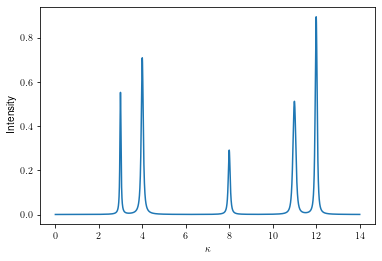

In [725]:
plt.plot(single_peak_copper_1.positive_diffraction_vectors, predicted_spectrum_copper_1)
plt.xlabel('$\\kappa$')
plt.ylabel('Intensity')


In [726]:
np.savetxt('benchmark_spectra/FCC_copper_twin.dat', np.vstack((single_peak_copper_1.positive_diffraction_vectors,
                                                        predicted_spectrum_copper_1.ravel())).T)

### FCC material

Copper 

$a = 0.361$

$b = 0.255$    

$m = 20$

$\sigma = 0.3$

$\rho = 0.01$

$q = 2.33$

$A = 0.03$

$R^* = 8$

$C_{h00} = 0.3029$



In [733]:
np.random.seed(3)
copper_sample_2 = {}
copper_sample_2['Ch00'] = 0.3029
copper_sample_2['lattice_constant'] = 0.361
copper_sample_2['b'] = 0.255
copper_sample_2['m'] = 20
copper_sample_2['sigma'] = 0.3
copper_sample_2['rho'] = 0.01
copper_sample_2['q'] = 2.33
copper_sample_2['A'] = 0.03
copper_sample_2['Rstar'] = 8
copper_sample_2['intensities'] = np.random.rand(5, 1)


In [734]:
single_peak_copper_2 = Peak(14, 1024 * 8, copper_sample_1['Ch00'], copper_sample_1['b'], copper_sample_1['lattice_constant'],
                   phase='fcc', backend = 'numpy', stacking_or_twin_fault='stacking', approximation_wilkens='polynomial')


In [735]:
predicted_spectrum_copper_2 = generate_multiple_peaks(single_peak_copper_2,
                                        copper_sample_2['m'],
                                        copper_sample_2['sigma'],
                                        copper_sample_2['A'],
                                        copper_sample_2['rho'],
                                        copper_sample_2['Rstar'],
                                        copper_sample_2['q'],
                                        peak_intensities = copper_sample_2['intensities'], intrinsic_or_extrinsic='intrinsic')

In [736]:
predicted_spectrum_copper_3 = generate_multiple_peaks(single_peak_copper_2,
                                        copper_sample_2['m'],
                                        copper_sample_2['sigma'],
                                        copper_sample_2['A'],
                                        copper_sample_2['rho'],
                                        copper_sample_2['Rstar'],
                                        copper_sample_2['q'],
                                        peak_intensities = copper_sample_2['intensities'], intrinsic_or_extrinsic='extrinsic')

Text(0, 0.5, 'Intensity')

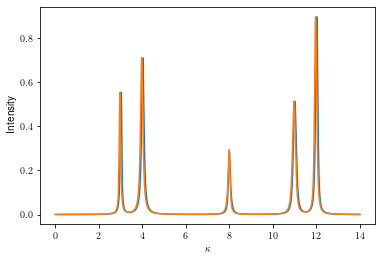

In [738]:
plt.plot(single_peak_copper_2.positive_diffraction_vectors, predicted_spectrum_copper_2)
plt.plot(single_peak_copper_2.positive_diffraction_vectors, predicted_spectrum_copper_3)

plt.xlabel('$\\kappa$')
plt.ylabel('Intensity')
#plt.xlim(10, 11.5)
#plt.ylim(0, 0.55)

In [740]:
np.savetxt('benchmark_spectra/FCC_copper_stacking_intrinsic.dat', np.vstack((single_peak_copper_2.positive_diffraction_vectors,
                                                        predicted_spectrum_copper_2.ravel())).T)
np.savetxt('benchmark_spectra/FCC_copper_stacking_extrinsic.dat', np.vstack((single_peak_copper_2.positive_diffraction_vectors,
                                                        predicted_spectrum_copper_3.ravel())).T)

In [669]:
lengthOfFrame = 2 * single_peak_copper_2.max_range_diffraction_vector

L = single_peak_copper_2.math.fftfreq(single_peak_copper_2.Nfourier, 
                                            lengthOfFrame / single_peak_copper_2.Nfourier).reshape(-1, 1) + 1e-7
N = len(L)
dell = L[1,:] - L[0,:]
factor = dell * N # normalization factor for the Fourier transform

In [670]:
h, k, l = 3, 1, 1

In [671]:
g = h**2 + k**2 + l**2

In [681]:
diagnostic, peak_3 = single_peak_copper_2.generate_convolutional_profile(L,
                                        copper_sample_2['m'],
                                        copper_sample_2['sigma'],
                                        0.3,
                                        copper_sample_2['rho'],
                                        copper_sample_2['Rstar'],
                                        copper_sample_2['q'], g, h, k, l, intrinsic_or_extrinsic='extrinsic')

In [683]:
ss = 0
for d in diagnostic[:-1]:
    ss += d['coeff']

In [706]:
subrefs = [np.fft.ifftshift(np.fft.ifft(d['coeff'], axis = 0 ), axes = 0) for d in diagnostic[:-1]]

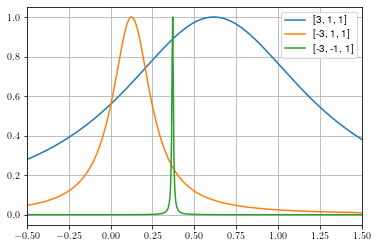

In [713]:
for i,s in enumerate(subrefs):
    plt.plot(single_peak_copper_2.diffraction_vectors, np.abs(s)/np.max(np.abs(s)),  '-', label = diagnostic[i]['subreflection'],)
plt.legend()
plt.xlim(-0.5, 1.5)
plt.grid()

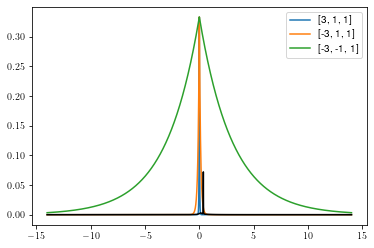

In [703]:
for i,s in enumerate(subrefs):
    plt.plot(single_peak_copper_2.diffraction_vectors, np.abs(s), label = diagnostic[i]['subreflection'])
plt.plot(single_peak_copper_2.diffraction_vectors, np.abs(ss12),  c= 'black')
plt.legend()
#plt.xlim(-0.6, 0.6)

(-0.6, 0.6)

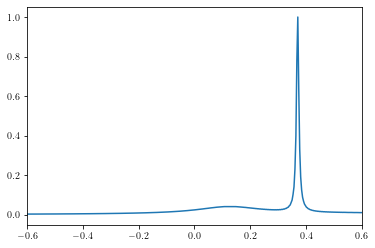

In [680]:
plt.plot(single_peak_copper_2.diffraction_vectors,peak_3)
plt.xlim(-0.6, 0.6)